# SSDLite 训练笔记（seed）

## 0. Imports & 配置

In [1]:
import math, time, json
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np

# === 你工程里的模块 ===
from sparrow.models.ssdlite import SSDLite                      # 模型骨架/头/neck  :contentReference[oaicite:4]{index=4}
from sparrow.datasets.coco_dets import create_dets_dataloader   # COCO det dataloader  :contentReference[oaicite:5]{index=5}
from sparrow.loss.ssdlite_loss import  (
    SSDLoss, pack_targets_for_ssd, generate_ssd_anchors,
)                                                               # 损失/锚框/编码  :contentReference[oaicite:6]{index=6}


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- 训练配置（可按需改）---
IMG_SIZE      = 320
BATCH_SIZE    = 32
EPOCHS        = 100
NUM_WORKERS   = 8
PIN_MEMORY    = True
DATA_ROOT     = "./data/coco2017_ssdlite_person_car"   # 根目录，含 images/{train2017,val2017} & annotations/*.json
SAVE_DIR      = "./outputs/ssdlite"
BACKBONE      = "mobilenet_v2"
WIDTH_MULT    = 1.0               # 与你选的权重/算力匹配
NUM_CLASSES   = 3                 # 含背景=1..80（COCO）
RATIOS        = (1.0, 2.0, 0.5)
SCALES        = (1.0, 1.26)
# STRIDES       = (8, 16, 32)       # 与默认 SSDLite 配置一致  :contentReference[oaicite:7]{index=7}
STRIDES = (4, 8, 16)

# 优化器 & 训练细节
LR            = 3e-3
WD            = 5e-4
WARMUP_EPOCHS = 3
AMP           = True              # 混合精度
NEG_POS_RATIO = 3                 # OHEM 负正比  :contentReference[oaicite:8]{index=8}

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

## 1. DataLoader（训练/验证）

In [2]:
aug_cfg = dict(
    use_color_aug=True, use_flip=True, use_rotate=True, rotate_deg=15.0,
    use_scale=True, scale_range=(0.75, 1.25), min_box_size=2.0
)

train_loader: DataLoader = create_dets_dataloader(
    dataset_root=DATA_ROOT, img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, aug_cfg=aug_cfg, is_train=True
)  # 训练默认带几何/颜色增广等  :contentReference[oaicite:9]{index=9}

val_loader: DataLoader = create_dets_dataloader(
    dataset_root=DATA_ROOT, img_size=IMG_SIZE, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, aug_cfg=dict(min_box_size=2.0), is_train=False
)  # 验证关闭大部分增广  :contentReference[oaicite:10]{index=10}

## 2. 构建模型 & 优化器/损失

In [3]:
model = SSDLite(
    num_classes=NUM_CLASSES, backbone=BACKBONE, width_mult=WIDTH_MULT,
    anchor_ratios=RATIOS, anchor_scales=SCALES, anchor_strides=STRIDES
).to(DEVICE)  # 输出三层 [P3,P4,P5]，每层 SSDLiteHead 产出 [B, H*W*A, C] 与 [B, H*W*A, 4]  :contentReference[oaicite:11]{index=11}

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
lr_sched  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler    = GradScaler(enabled=AMP)

# 含背景的 SSDLoss（CrossEntropy + SmoothL1 + OHEM）
criterion = SSDLoss(num_classes=NUM_CLASSES, alpha=1.0, neg_pos_ratio=NEG_POS_RATIO, reg_type="smoothl1")

In [4]:
# ----- 可选：训练前尝试加载已有最优权重 -----
PERSON_IDX = 1   # 你的子集映射里：person -> id 1
CAR_IDX    = 2   # car   -> id 2

BEST_CKPT = Path(SAVE_DIR) / "best.pt"
if BEST_CKPT.exists():
    ckpt = torch.load(BEST_CKPT, map_location="cpu")
    sd = ckpt["model_state"] if "model_state" in ckpt else ckpt
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print(f"[resume] loaded: {BEST_CKPT}")
    if missing:   print(f"[resume] missing keys: {len(missing)} (showing first 8) -> {missing[:8]}")
    if unexpected:print(f"[resume] unexpected keys: {len(unexpected)} (showing first 8) -> {unexpected[:8]}")
else:
    print(f"[resume] no existing checkpoint at {BEST_CKPT}, training from scratch.")


[resume] no existing checkpoint at outputs/ssdlite/best.pt, training from scratch.


## 3. 预先计算 anchors（按实际特征图尺寸）

> 我们用一个 dummy batch 前向，拿到 P3/P4/P5 的 `H,W`，再用 **与训练一致的 strides/ratios/scales** 生成**归一化 (cx,cy,w,h)** anchors；这与损失里的编码/解码严格对齐（variances=(0.1,0.2)）。

In [5]:
@torch.no_grad()
def infer_feat_shapes_and_make_anchors(model, img_size: int):
    model.eval()
    dummy = torch.zeros(1, 3, img_size, img_size, device=DEVICE)
    out = model(dummy)
    # 从 cls_logits 每层长度反推出 H*W*A，再用 strides 反推 H,W（已知 A=len(ratios)*len(scales)）
    A = len(RATIOS) * len(SCALES)
    feat_shapes = []
    for cls in out["cls_logits"]:
        _, NA, _ = cls.shape
        HW = NA // A
        H  = int(round(math.sqrt(HW)))
        W  = HW // H
        feat_shapes.append((H, W))
    anchors = generate_ssd_anchors(
        img_size=img_size, feat_shapes=feat_shapes, strides=list(STRIDES),
        ratios=RATIOS, scales=SCALES
    ).to(DEVICE)  # [A_total,4], 归一化 cxcywh  :contentReference[oaicite:14]{index=14}
    A_total = anchors.shape[0]
    print("feat_shapes:", feat_shapes, " anchors:", A_total)
    return feat_shapes, anchors

feat_shapes, anchors_cxcywh = infer_feat_shapes_and_make_anchors(model, IMG_SIZE)

feat_shapes: [(80, 80), (40, 40), (20, 20)]  anchors: 50400


In [6]:
@torch.no_grad()
def probe_fg_scores(model, loader, max_batches=3):
    """
    轻量化探针：在验证集上抽几批，统计前景段(1..C-1) softmax 的 max/mean。
    max 上升到 0.35+ 时，用 conf_thr=0.35 就能看到框了。
    """
    model.eval()
    fg_max, fg_mean, n_seen = 0.0, 0.0, 0
    for bi, (imgs, _, _) in enumerate(loader):
        if bi >= max_batches: break
        imgs = imgs.to(DEVICE, non_blocking=True)
        out  = model(imgs)
        cls  = torch.cat(out["cls_logits"], dim=1)  # [B, A, C]
        probs = torch.softmax(cls, dim=-1)          # 含背景 softmax
        fg = probs[..., 1:]                         # 前景段
        fg_max  = max(fg_max, float(fg.max().cpu()))
        fg_mean += float(fg.mean().cpu())
        n_seen  += 1
    fg_mean /= max(1, n_seen)
    return fg_max, fg_mean


## 4. 训练循环（与损失接口完全对齐）

In [7]:
use_amp = AMP and (DEVICE == 'cuda')

def to_device_packed(packed, device):
    def _move(x):
        if torch.is_tensor(x):
            return x.to(device, non_blocking=True)
        if isinstance(x, (list, tuple)):
            return type(x)(_move(t) for t in x)
        if isinstance(x, dict):
            return {k: _move(v) for k, v in x.items()}
        return x
    return _move(packed)

best_val = 1e9
for epoch in range(1, EPOCHS+1):
    model.train()
    meter = {"loss": 0.0, "cls": 0.0, "reg": 0.0, "n": 0}
    t0 = time.time()

    for imgs, targets_list, _ in train_loader:
        imgs = imgs.to(DEVICE, non_blocking=True)

        packed = pack_targets_for_ssd(targets_list, img_size=IMG_SIZE)
        packed = to_device_packed(packed, DEVICE)

        optimizer.zero_grad(set_to_none=True)
        if use_amp:
            from contextlib import nullcontext  # 仅为补全命名
            ctx = autocast(device_type='cuda', enabled=True)
        else:
            from contextlib import nullcontext
            ctx = nullcontext()

        with ctx:
            out = model(imgs)
            cls_logits = torch.cat(out["cls_logits"], dim=1)  # [B, A_total, C]
            bbox_regs  = torch.cat(out["bbox_regs"],  dim=1)  # [B, A_total, 4]
            assert cls_logits.shape[1] == anchors_cxcywh.shape[0], "anchors 与输出长度不一致"

            loss, m = criterion(cls_logits, bbox_regs, anchors_cxcywh, packed)

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        meter["loss"] += float(loss.detach().cpu())
        meter["cls"]  += m["loss_cls"]
        meter["reg"]  += m["loss_reg"]
        meter["n"]    += 1

    lr_sched.step()
    dt = time.time() - t0
    tr_log = {k: v / max(1, meter["n"]) for k, v in meter.items() if k != "n"}
    print(f"[Epoch {epoch:03d}] train: {tr_log}  time={dt:.1f}s  lr={optimizer.param_groups[0]['lr']:.3e}")

    # ---------------- 验证 ----------------
    model.eval()
    with torch.no_grad():
        vm = {"loss": 0.0, "cls": 0.0, "reg": 0.0, "n": 0}
        for imgs, targets_list, _ in val_loader:
            imgs = imgs.to(DEVICE, non_blocking=True)
            packed = pack_targets_for_ssd(targets_list, img_size=IMG_SIZE)
            packed = to_device_packed(packed, DEVICE)

            out = model(imgs)
            cls_logits = torch.cat(out["cls_logits"], dim=1)
            bbox_regs  = torch.cat(out["bbox_regs"],  dim=1)
            loss, m = criterion(cls_logits, bbox_regs, anchors_cxcywh, packed)

            vm["loss"] += float(loss.detach().cpu())
            vm["cls"]  += m["loss_cls"]
            vm["reg"]  += m["loss_reg"]
            vm["n"]    += 1

        val_log = {k: v / max(1, vm["n"]) for k, v in vm.items() if k != "n"}
    print(f"[Epoch {epoch:03d}] valid: {val_log}")

    # ★新增：前景分数探针
    fg_max, fg_mean = probe_fg_scores(model, val_loader, max_batches=3)
    print(f"[Epoch {epoch:03d}] probe: fg_max={fg_max:.3f}  fg_mean={fg_mean:.3f}")

    if val_log["loss"] < best_val:
        best_val = val_log["loss"]
        ckpt = {"model_state": model.state_dict(), "epoch": epoch, "best_score": best_val}
        torch.save(ckpt, f"{SAVE_DIR}/best.pt")
        print(f"  ✓ saved best to {SAVE_DIR}/best.pt")


[Epoch 001] train: {'loss': 6.932214095674712, 'cls': 1.0373471985603202, 'reg': 5.894866906363388}  time=19.5s  lr=2.999e-03
[Epoch 001] valid: {'loss': 6.7484453042348225, 'cls': 0.935559211174647, 'reg': 5.812886065906948}
[Epoch 001] probe: fg_max=0.565  fg_mean=0.253
  ✓ saved best to ./outputs/ssdlite/best.pt
[Epoch 002] train: {'loss': 5.355957220340597, 'cls': 0.9071456245307264, 'reg': 4.448811589986429}  time=17.3s  lr=2.997e-03
[Epoch 002] valid: {'loss': 5.924844143125746, 'cls': 0.825089736117257, 'reg': 5.0997544023725725}
[Epoch 002] probe: fg_max=0.439  fg_mean=0.200
  ✓ saved best to ./outputs/ssdlite/best.pt
[Epoch 003] train: {'loss': 5.1136575019222565, 'cls': 0.8227990290214275, 'reg': 4.2908584646794985}  time=17.2s  lr=2.993e-03
[Epoch 003] valid: {'loss': 5.656894659996032, 'cls': 0.7555495255523258, 'reg': 4.901345125834147}
[Epoch 003] probe: fg_max=0.386  fg_mean=0.160
  ✓ saved best to ./outputs/ssdlite/best.pt
[Epoch 004] train: {'loss': 4.8917333134289445,

## 5. 简易推理/可视化（验证 anchor/解码逻辑）

> 解码要与训练**同一套** variances 与 anchor 定义，直接复用 `decode_deltas_to_xyxy`；运行在 **letterbox 坐标**，再按比例映射回原图。

feat_shapes: [(80, 80), (40, 40), (20, 20)]  anchors: 50400
[DEBUG] fg: min=0.0248, max=0.2168, mean=0.1124
[DEBUG] #cands >= 0.2: 30 (top5=[0.21372963 0.21593203 0.21607235 0.21671078 0.21681032])


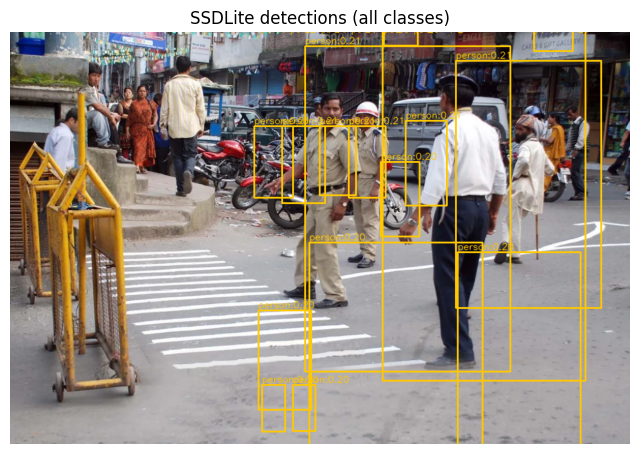

In [9]:
# ---- 1) 先把最优权重 load 进来（推理前做一次）----
ckpt = torch.load(f"{SAVE_DIR}/best.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

# 如果你在训练阶段之后有改过 IMG_SIZE/STRIDES/RATIOS/SCALES 或重新构建过 model
# 记得重生成 anchors：
feat_shapes, anchors_cxcywh = infer_feat_shapes_and_make_anchors(model, IMG_SIZE)  # 已有函数

# ---- 2) 多类推理 + 兜底可视化 ----
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sparrow.loss.ssdlite_loss import decode_deltas_to_xyxy

def nms_np(boxes, scores, iou=0.5, max_det=100):
    order = scores.argsort()[::-1]
    keep = []
    while order.size > 0 and len(keep) < max_det:
        i = order[0]; keep.append(i)
        if order.size == 1: break
        xx1 = np.maximum(boxes[i,0], boxes[order[1:],0])
        yy1 = np.maximum(boxes[i,1], boxes[order[1:],1])
        xx2 = np.minimum(boxes[i,2], boxes[order[1:],2])
        yy2 = np.minimum(boxes[i,3], boxes[order[1:],3])
        w = np.clip(xx2-xx1, 0, None); h = np.clip(yy2-yy1, 0, None)
        inter = w*h
        area_i = (boxes[i,2]-boxes[i,0])*(boxes[i,3]-boxes[i,1])
        area_o = (boxes[order[1:],2]-boxes[order[1:],0])*(boxes[order[1:],3]-boxes[order[1:],1])
        ovr = inter / (area_i + area_o - inter + 1e-6)
        order = order[1:][ovr < iou]
    return np.array(keep, dtype=np.int64)

@torch.no_grad()
def infer_multiclass(img_bgr, model, conf_thr=0.20, iou_thr=0.5, max_det=100, topk_debug=50):
    model.eval()

    # letterbox -> 与训练一致
    h0, w0 = img_bgr.shape[:2]
    scale = min(IMG_SIZE/h0, IMG_SIZE/w0)
    nh, nw = int(round(h0*scale)), int(round(w0*scale))
    canvas = np.full((IMG_SIZE, IMG_SIZE, 3), 114, dtype=np.uint8)
    top, left = (IMG_SIZE-nh)//2, (IMG_SIZE-nw)//2
    canvas[top:top+nh, left:left+nw] = cv2.resize(img_bgr, (nw, nh))
    rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)

    inp = torch.from_numpy(rgb.transpose(2,0,1)).float().unsqueeze(0)/255.0
    inp = inp.to(DEVICE)

    out = model(inp)
    cls = torch.cat(out["cls_logits"], dim=1)  # [1, A, C]
    reg = torch.cat(out["bbox_regs"],  dim=1)  # [1, A, 4]
    probs = torch.softmax(cls[0], dim=-1)      # [A, C]

    # 打印一下前景分布
    fg = probs[:, 1:]
    print(f"[DEBUG] fg: min={float(fg.min()):.4f}, max={float(fg.max()):.4f}, mean={float(fg.mean()):.4f}")

    # 解码到 letterbox 坐标（像素）
    deltas = reg[0]
    xyxy_norm = decode_deltas_to_xyxy(deltas, anchors_cxcywh).clamp_(0, 1)
    boxes_lbox_all = (xyxy_norm * IMG_SIZE).detach().cpu().numpy()

    # 对每个 anchor，取前景类别 argmax（忽略背景0）
    probs_np = probs.detach().cpu().numpy()
    scores_fg = probs_np[:, 1:]                         # [A, C-1]
    labels_fg = scores_fg.argmax(1) + 1                 # 回到 1..C-1
    scores_max = scores_fg.max(1)                       # 每个 anchor 的前景最大分
    mask = scores_max >= conf_thr
    boxes = boxes_lbox_all[mask]
    scores = scores_max[mask]
    labels = labels_fg[mask]

    print(f"[DEBUG] #cands >= {conf_thr}: {boxes.shape[0]} (top5={np.sort(scores)[-5:] if boxes.shape[0]>5 else scores})")

    # NMS：可按类分别做，也可混合做；这里按类做
    final_boxes, final_scores, final_labels = [], [], []
    for c in np.unique(labels):
        m = labels == c
        if m.sum() == 0: continue
        keep = nms_np(boxes[m], scores[m], iou=iou_thr, max_det=max_det)
        final_boxes.append(boxes[m][keep])
        final_scores.append(scores[m][keep])
        final_labels.append(np.full_like(scores[m][keep], c))

    if len(final_boxes) > 0:
        final_boxes  = np.concatenate(final_boxes,  axis=0)
        final_scores = np.concatenate(final_scores, axis=0)
        final_labels = np.concatenate(final_labels, axis=0)
    else:
        # 兜底：阈值太高的话，取全局 top-k 看看
        order = scores_max.argsort()[::-1][:topk_debug]
        final_boxes  = boxes_lbox_all[order]
        final_scores = scores_max[order]
        final_labels = labels_fg[order]
        print(f"[DEBUG] fallback top-{topk_debug}: best5={np.sort(final_scores)[-5:]}")

    # 映回原图
    out_boxes = []
    for (x1,y1,x2,y2) in final_boxes:
        X1 = (x1 - left) / scale
        Y1 = (y1 - top ) / scale
        X2 = (x2 - left) / scale
        Y2 = (y2 - top ) / scale
        out_boxes.append([X1,Y1,X2,Y2])

    return np.array(out_boxes, np.float32), final_scores, final_labels

# ==== 测一下 ====
img = cv2.imread("./india_road.png")
boxes, scores, labels = infer_multiclass(img, model, conf_thr=0.20, iou_thr=0.5, max_det=100)

# 画框（简单给两类名；如果你的数据集只有 person/car，它们通常映射成 1/2）
id2name = {1: "person", 2: "car"}
vis = img.copy()
for b, s, l in zip(boxes.astype(int), scores, labels):
    cv2.rectangle(vis, (b[0], b[1]), (b[2], b[3]), (0, 200, 255), 2)
    name = id2name.get(int(l), str(int(l)))
    cv2.putText(vis, f"{name}:{s:.2f}", (b[0], max(0, b[1]-4)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,200,255), 1, cv2.LINE_AA)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis('off'); plt.title("SSDLite detections (all classes)")
plt.show()